# Behavioral Patterns

The behavioral patterns are guidelines suggested to create classes that allows to communicate objects to each other. The goal of the behavioral patterns is to make those interactions easier and more understandable.

The five creational patterns available are:
1. Chain of Responsability
2. Command
3. Iterator
4. Mediator
5. Memento
6. Observer
7. State
8. Strategy
9. Template method
10. Visitor

Again, we are going to be convering eaach of the possible patterns and making some examples in the context of machine learning engineering.

# Observer

**What is an observer?**

This is a design focused on creating a way to execute some changes given events. This pattern needs two classes the `Publisher` and the `Suscriber`. The `Publisher` gives off the events happing, while the `Suscriber` executes a given action when an specific event has occurred.

**When should we use it?**

This design pattern is suitable when some code or application mechanisms depends their execution on triggers.

**Analogy**:

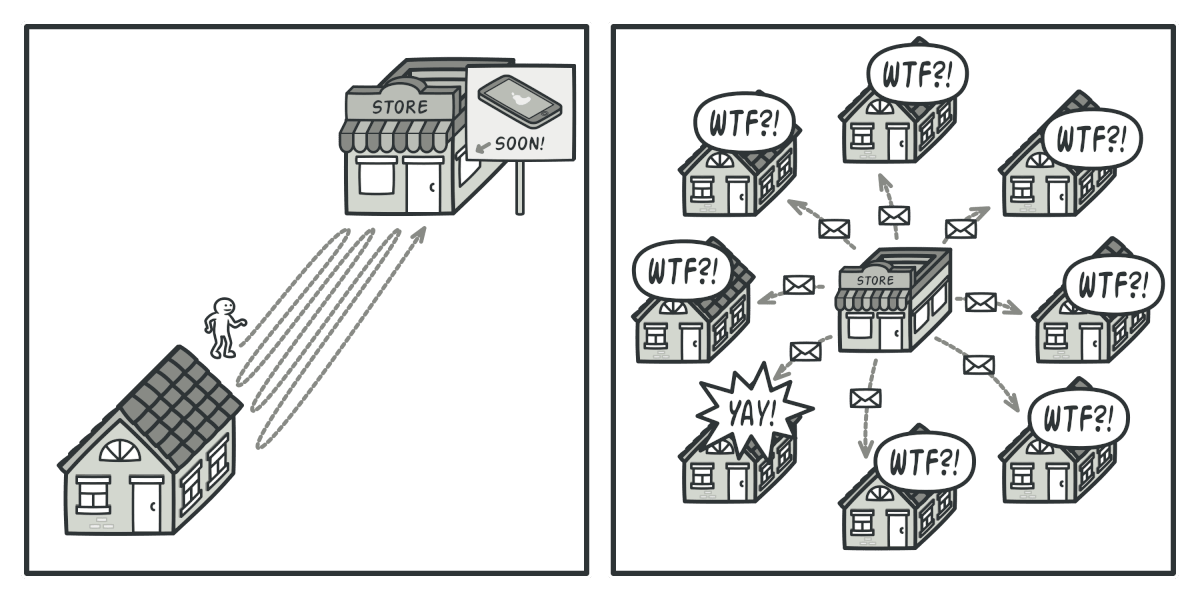

Instead of going to a store to check if a new item is available, the store (**publisher**) can notify to all houses (**suscribers**) when the new item is available. The *suscribers* will execute the action if wanted.

**Scenario**

You're a lead machine learning engineer. You have designed a pipeline that process normalizes data with a Standard Scaler and then trains a random forest model. Each time, you're data drifts from the KS value lower than 0.8, you should trigger a model retraining pipeline. In addition, you need to send a notification to the machine learning engineer who created this model. Once, the pipeline was retrained, you'll need to send a notification about the new model metrics obtained.

Let's import some basic data just for creating a simple pipeline

In [172]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from abc import ABC

import pandas as pd
import numpy as np

In [173]:
df = load_diabetes(as_frame=True, return_X_y=True)

In [174]:
df = pd.concat([df[0], df[1]], axis=1)

## Antipattern

One thing to do it wrongly, it is to create a god object which performs most of the actions needed for the notifications and retraining. 

In [175]:
class SmartPipeline:
    def __init__(self):
        self.model = None

    def _normalize_data(self, df: pd.DataFrame, columns: list) -> pd.DataFrame:
        df = df.copy()
        scaler = StandardScaler()
        df[columns] = scaler.fit_transform(df[columns])
        return df

    def _train_model(self, df: pd.DataFrame, target: str) -> RandomForestRegressor:
        X = df.drop(columns=[target])
        y = df[target]
        model = RandomForestRegressor()
        model.fit(X, y)
        return model

    def check_data_drift(self, df: pd.DataFrame, cols: list, threshold: float) -> bool:
        print("Checking for data drift...")
        if threshold < np.random.rand():
            self.notify_data_drift()

    def notify_data_drift(self) -> None:
        print("Data drift detected!")

    def notify_new_model(self) -> None:
        print("A new model has been trained!")

    def fit(self, df: pd.DataFrame, target: str, normalize_columns: list) -> None:
        df = self._normalize_data(df, normalize_columns)
        self.model = self._train_model(df, target)

    def evaluate(self) -> None:
        print("Model is being evaluated")

Let's define the pipeline

In [176]:
pipeline = SmartPipeline()

Let's train the pipeline

In [177]:
pipeline.fit(df, target="target", normalize_columns=df.columns[:-1].tolist())

Let's emulate the data drift

In [178]:
pipeline.check_data_drift(df, cols=df.columns[:-1].tolist(), threshold=0.01)

Checking for data drift...
Data drift detected!


Let's notify the user

In [179]:
pipeline.notify_data_drift()

Data drift detected!


Let's assume we retrain the model (`model.fit()`), and then we just can simply notify the new model

In [180]:
pipeline.notify_new_model()
pipeline.evaluate()

A new model has been trained!
Model is being evaluated


As you see before, we are breaking several SOLID principles. We are breaking the single responsability principle because our class does many things. We are breaking the open-closed because any change in the pipeline might breake all the implementation. 

**How to solve this antipattern?**

1. Define the pipeline as a suscriber
2. Define the notifications as another suscriber
3. Define a class which is the publisher

## Pattern

This will be the mother class of the `Suscriber`

In [181]:
class Publisher(ABC):
    def __init__(self) -> None:
        self.observers = []

    def run(self, event: str) -> None:
        for observer in self.observers:
            observer.update(event)

    def attach(self, observer) -> None:
        self.observers.append(observer)

We can inherit from this base class to create one focused on data-driven events

In [182]:
class DataPublisher(Publisher):
    def notify_data_drift(self) -> None:
        if np.random.rand() > 0.5:
            self.run("data_drift")

Now, we can create the suscribers

In [183]:
class NotificationNewModelTraining:
    def update(self, event: str) -> None:
        if event == "data_drift":
            print("A new model is being trained!")

Let's create another suscriber for the model evaluation

In [184]:
class NotificationModelEvaluation:
    def update(self, event: str) -> None:
        if event == "data_drift":
            print("Model is being evaluated!")

We split the pipeline into a different class

In [185]:
class NewPipeline:
    def __init__(self):
        self.model = None

    def _normalize_data(self, df: pd.DataFrame, columns: list) -> pd.DataFrame:
        df = df.copy()
        scaler = StandardScaler()
        df[columns] = scaler.fit_transform(df[columns])
        return df

    def _train_model(self, df: pd.DataFrame, target: str) -> RandomForestRegressor:
        X = df.drop(columns=[target])
        y = df[target]
        model = RandomForestRegressor()
        model.fit(X, y)
        return model

    def fit(self, df: pd.DataFrame, target: str, normalize_columns: list) -> None:
        df = self._normalize_data(df, normalize_columns)
        self.model = self._train_model(df, target)

We create a suscriber for the pipeline

In [186]:
class PipelineRetraining:
    def __init__(self, df: pd.DataFrame, target: str, normalize_columns: list):
        self.pipeline = NewPipeline()
        self.df = df
        self.target = target
        self.normalize_columns = normalize_columns

    def update(self, event: str) -> None:
        if event == "data_drift":
            print("Retraining in process. Please wait ...")
            self.pipeline.fit(
                self.df, target=self.target, normalize_columns=self.normalize_columns
            )
            print("Model retrained!")

Now, we have everything we need

1. Create the Publisher

In [187]:
data_publisher = DataPublisher()

2. Attach the suscribers

In [188]:
notification_suscriber = NotificationNewModelTraining()
pipeline_retraining = PipelineRetraining(
    df, target="target", normalize_columns=df.columns[:-1].tolist()
)
model_evaluation = NotificationModelEvaluation()

3. Let's attach the suscribers

In [189]:
data_publisher.attach(notification_suscriber)
data_publisher.attach(pipeline_retraining)
data_publisher.attach(model_evaluation)

4. Execute given an event

In [191]:
data_publisher.notify_data_drift()

A new model is being trained!
Retraining in process. Please wait ...
Model retrained!
Model is being evaluated!
